In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('data', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
plt.style.use('classic')

In [6]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [7]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [8]:
def cluster_centroids(vectors):
    centroids = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        centroids[k] = scipy.sparse.csr_matrix(matx.sum(axis=0) / len(values))
    return centroids

In [9]:
def inter_cluster_overall_similarity(vectors):
    topic_centroids = cluster_centroids(vectors)
    matx_c = scipy.sparse.vstack((topic_centroids.values()))
    matx_c_c = cosine_similarity(matx_c)
    matx_c_c_s = sum(matx_c_c) / len(matx_c_c)

    return sum(matx_c_c_s) / len(matx_c_c_s)

In [10]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [11]:
import re

#compile regular expressions that match repeated characters and emoji unicode
emoji = re.compile(u'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]',re.UNICODE)
multiple = re.compile(r"(.)\1{1,}", re.DOTALL)

def text_format(text):

    #strip emoji
    stripped = emoji.sub('',text)

    #strip URLs
    stripped = re.sub(r'http[s]?[^\s]+','', stripped)

    #strip html '&amp;', '&lt;', etc.  
    stripped = re.sub(r'[\&].*;','',stripped)

    #strip punctuation
    stripped = re.sub(r'[#|\!|\-|\+|:|//]', " ", stripped)

    #strip whitespace down to one.
    stripped = re.sub('[\s]+' ,' ', stripped).strip()

    #strip multiple occurrences of letters
    stripped = multiple.sub(r"\1\1", stripped)

    #strip all non-latin characters
    stripped = re.sub('[^a-zA-Z0-9|\']', " ", stripped).strip()

    return stripped

In [12]:
from nltk.tag import pos_tag

print("Building vocabulary...")

docs = {}
doc_tokens = {}
count = 0

for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            text = text_format(text)
            tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
            words = [word for word,pos in tagged if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
            docs[doc['id']]["text"] = " ".join(words)
            clear_output(wait=True)
            count += 1
            print(count)

9095


# TF-IDF Vectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

(9095, 69281)


In [ ]:
pickle.dump(X_tfidf, open('results/X_tfidf.pickle', 'wb'))

In [18]:
X_tfidf = pickle.load(open('results/X_tfidf.pickle', 'rb'))

print(X_tfidf.shape)

(9095, 69281)


# Add Keywords to docs

In [14]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [15]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['top_tfidf'] = top_feats_in_doc(X_tfidf, vectorizer_tfidf.get_feature_names(), i, 50)
    
print(docs['2016-05-20-28']['top_tfidf'])

# Add Vector to docs

In [47]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

<1x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 196 stored elements in Compressed Sparse Row format>

# Save & Load Docs

In [69]:
pickle.dump(docs, open('results/docs.pickle', 'wb'))

In [13]:
docs = pickle.load(open('results/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['section_id', 'apiUrl', 'webTitle', 'top_tfidf', 'body', 'guardianId', 'sectionId', 'authors', 'text', 'id', 'webUrl', 'keyword', 'webPublicationDate', 'tfidf', 'mod_topic', 'tags'])

In [13]:
sorted_docs = sorted(docs.items(), key=lambda x: x[0], reverse=True)
token_keys = [x[0] for x in sorted_docs]
token_values = [x[1]["text"] for x in sorted_docs]
print(len(token_values))

9095


# Network-based Approach - Build the graph from scratch

In [ ]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

In [ ]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
cos_sims = cosine_similarity(X_tfidf)
for i, source in enumerate(token_keys):
    sims = cos_sims[i]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = sims[j]
        count += 1

print(g.ecount())

In [ ]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

In [ ]:
g.es[1]['weight']

# Apply Modularity

Create New Sub Graph or Use below function to load from data

In [ ]:
sub_g = g.es.select(weight_ge=0.2).subgraph()

In [ ]:
sub_g.write_gml('results/graph_02.gml')

Load from Data

In [17]:
sub_g = ig.Graph.Read_GML('results/graph_02.gml')

In [18]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [19]:
sg = sub_g.es.select(weight_ge=0.2).subgraph()
communities = sg.community_multilevel(weights='weight',return_levels=True)
for com in communities:
    print(max(com.membership) + 1)
community = communities[-1]
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("NO of Communities {}".format(max(community.membership) + 1))
print("Modularity {}".format(sg.modularity(community.membership)))

586
166
140
139
Nodes 8213
Edges 132243
LCC 7950
NO of Communities 139
Modularity 0.7987487477056004


# Network Topic Distribution

In [20]:
def network_to_topics(com):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(v['name'])
    
    net_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        net_topics[count] = value
        count += 1
        
    return net_topics

In [21]:
net_topics = network_to_topics(community)
len(net_topics)

139

In [22]:
def community_to_size_chart(net_topics):
    x_data = []
    y_data = []
    for key, value in net_topics.items():
        if key <= 50:
            x_data.append(key)
            y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('w')
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data)
    plt.title("Louvain Modularity")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.tight_layout()
    fig.savefig('tmp/size_chart_net.png')
    plt.show()

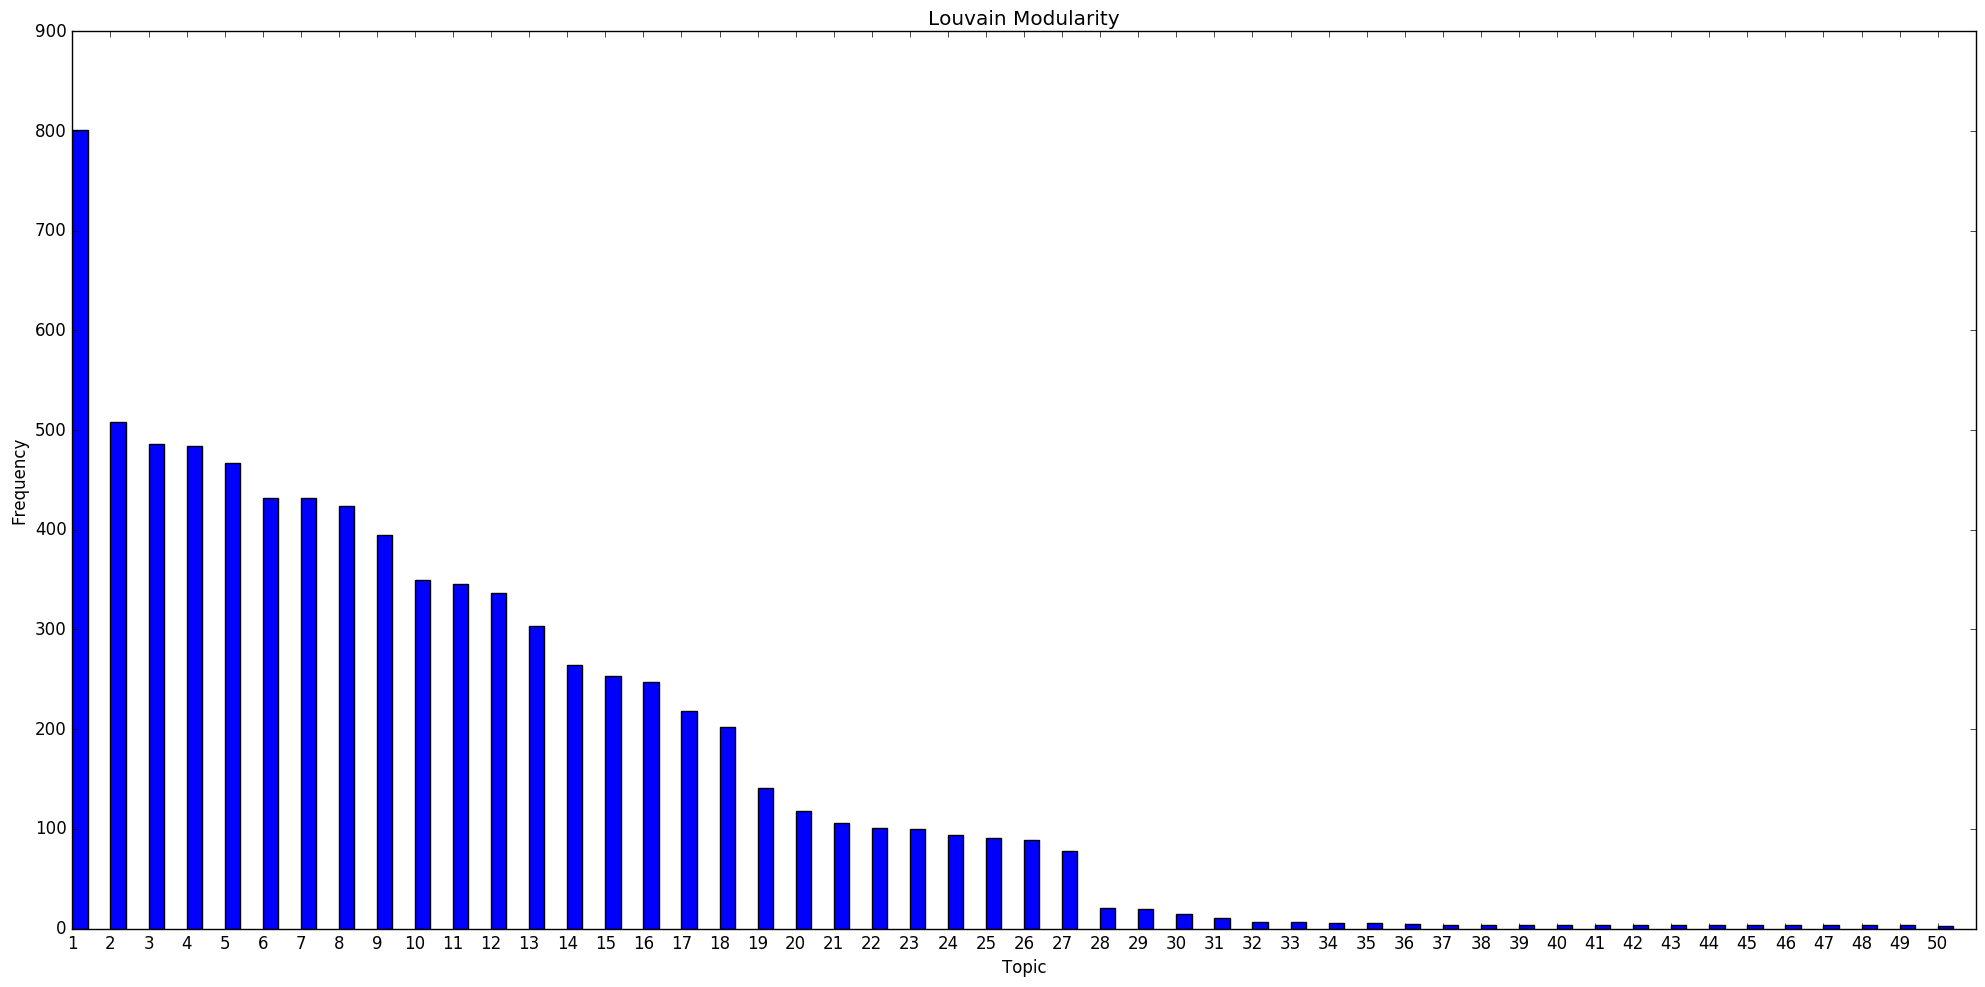

In [23]:
community_to_size_chart({k: v for k, v in net_topics.items()})

In [24]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.title("Louvain Modularity")
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")
    plt.tight_layout()
    fig.savefig('tmp/prob_chart_mod.png')
    plt.show()

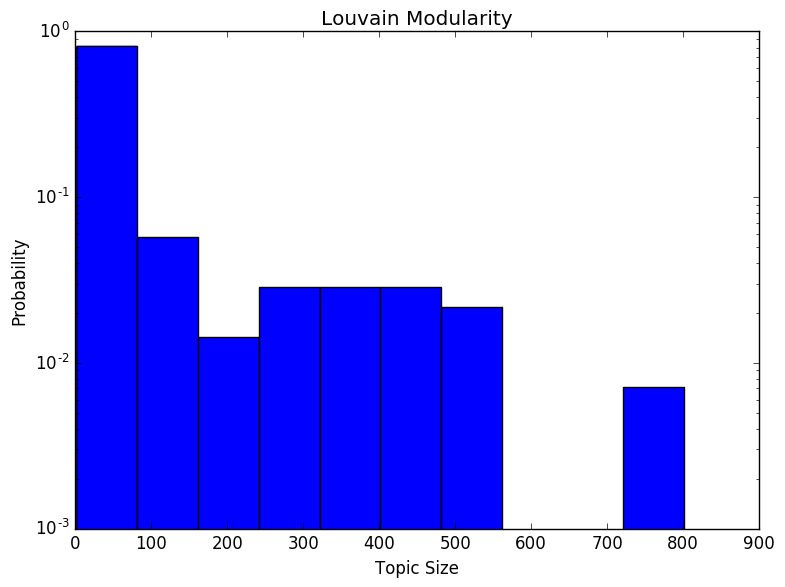

In [25]:
topics_to_prob_dist(net_topics)

In [26]:
net_tfidf_topics = {}
for k, vs in net_topics.items():
    net_tfidf_topics[k] = []
    for v in vs:
        net_tfidf_topics[k].append(docs[v]['tfidf'])

In [27]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(net_tfidf_topics)))
print("Inter Cluster Overall Similarity Top {0:.3f}".format(inter_cluster_overall_similarity(net_tfidf_topics)))

Overall Similarity 0.525
Inter Cluster Overall Similarity Top 0.051


# Reduced Network

In [28]:
reduced_docs = {}
for v in sg.vs():
    reduced_docs[v['name']] = docs[v['name']]

In [29]:
sorted_reduced_docs = sorted(reduced_docs.items(), key=lambda x: x[0], reverse=True)

In [30]:
reduced_tfidf_values = [x[1]['tfidf'] for x in sorted_reduced_docs]

In [31]:
reduced_X_tfidf = scipy.sparse.vstack((reduced_tfidf_values))
reduced_X_tfidf

<8213x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 1089809 stored elements in Compressed Sparse Row format>

In [32]:
reduced_token_keys = [x[0] for x in sorted_reduced_docs]
reduced_token_values = [x[1]["text"] for x in sorted_reduced_docs]
print(len(reduced_token_values))

8213


# Hierarchical Clustering

In [33]:
from scipy.cluster.hierarchy import average
from scipy.cluster.hierarchy import linkage

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(reduced_X_tfidf)

In [35]:
print("Start Hierarchical Clustering...")

linkage_matrix = average(dist)

print("Done Hierarchical Clustering...")

Start Hierarchical Clustering...
Done Hierarchical Clustering...


In [ ]:
linkage_matrix = pickle.load(open('results/linkage_matrix.pickle', 'rb'))

In [37]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cluster_assignments = fcluster(linkage_matrix, 139, criterion="maxclust")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

for k, ind in enumerate(indices):
    for i in ind:
        reduced_docs[reduced_token_keys[i]]['hclust'] = k

139 clusters
Giant Size: 3841


In [38]:
hclust_items = []
for item in reduced_docs.items():
    hclust_items.append((item[0], item[1]['hclust']))
len(hclust_items)

8213

In [39]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in hclust_items:
    topic_no = item[1]
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

hclust_topics = {}
count = 1
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    hclust_topics[count] = value
    count += 1

139


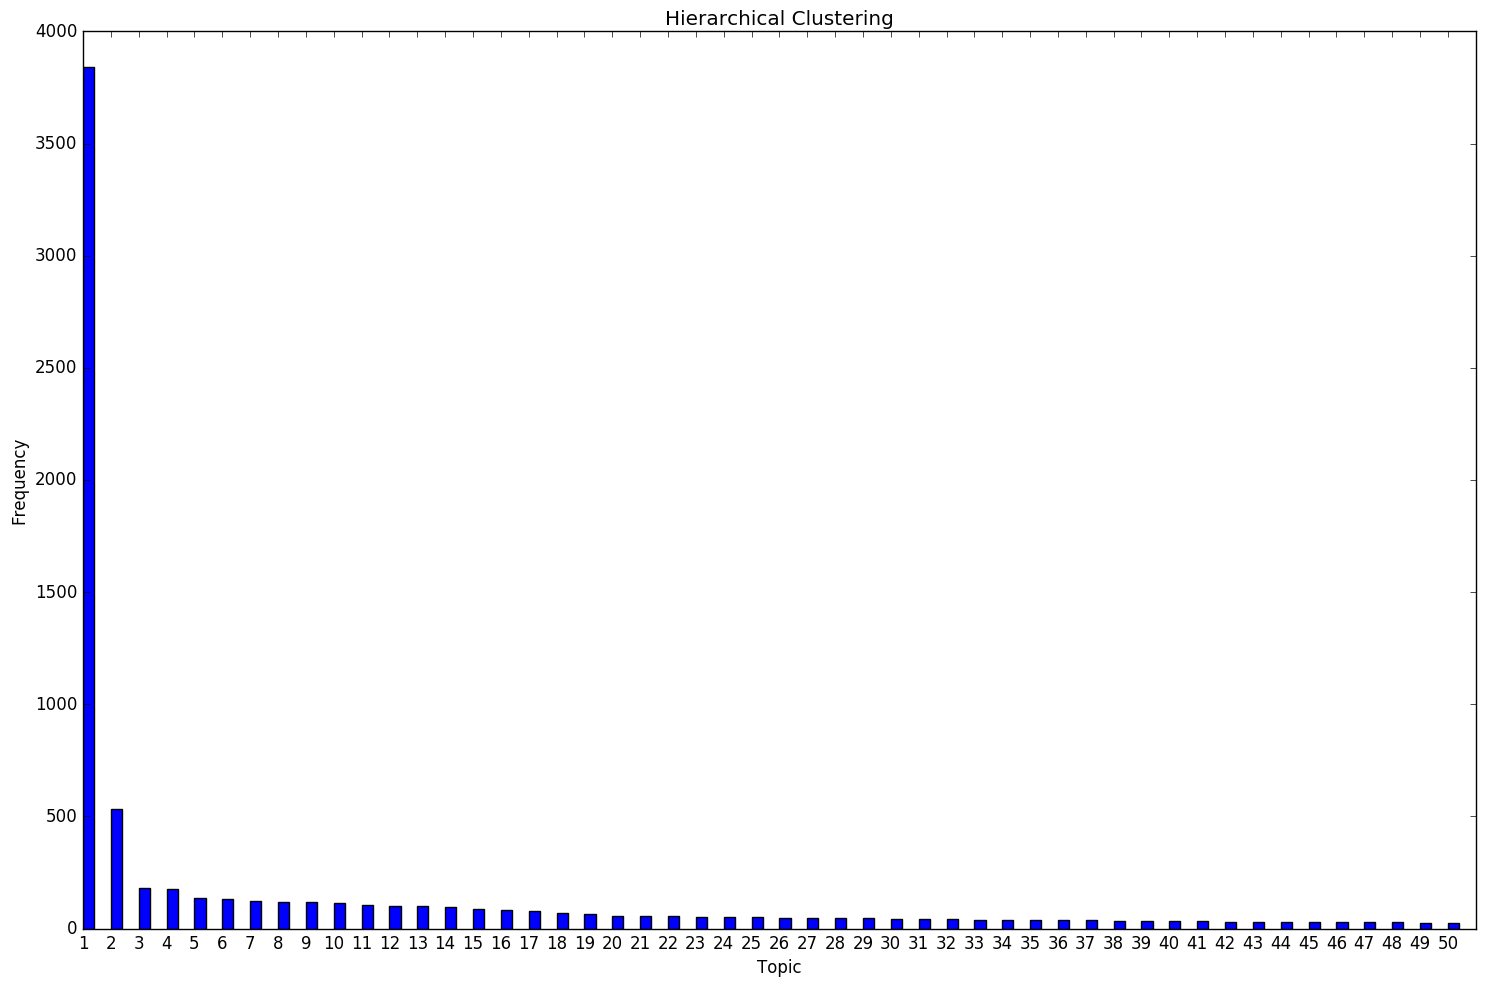

In [40]:
x_data = []
y_data = []
for key, value in sorted(hclust_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 50:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('w')
plt.bar(ind, y_data)
plt.xticks(ind, x_data)
plt.title("Hierarchical Clustering")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.tight_layout()
fig.savefig('tmp/size_chart_hclust.png')
plt.show()

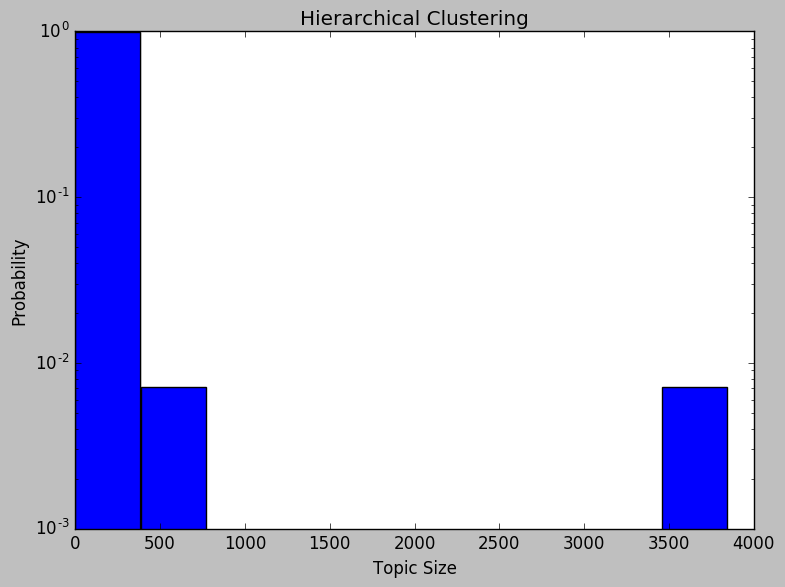

In [41]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    fig = plt.figure()
    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.title("Hierarchical Clustering")
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")
    plt.tight_layout()
    fig.savefig('tmp/prob_chart_hclust.png')
    
topics_to_prob_dist(hclust_topics)

In [42]:
hclust_tfidf_topics = {}

for k, vs in hclust_topics.items():
    hclust_tfidf_topics[k] = []
    for v in vs:
        hclust_tfidf_topics[k].append(docs[v]['tfidf'])

In [43]:
hclust_labels_true = {}

for k, vs in hclust_topics.items():
    hclust_labels_true[k] = []
    for v in vs:
        hclust_labels_true[k].append(docs[v]['section_id'])

In [44]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(hclust_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(hclust_tfidf_topics)))

Overall Similarity 0.449
Inter Cluster 0.113


# K-means

In [45]:
from sklearn.cluster import KMeans

In [46]:
num_clusters = 139

In [48]:
km = KMeans(n_clusters=num_clusters, random_state=5000)

%time km.fit(reduced_X_tfidf)

CPU times: user 7min 4s, sys: 19.2 s, total: 7min 23s
Wall time: 7min 27s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=139, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=5000, tol=0.0001,
    verbose=0)

In [49]:
km = pickle.load(open('results/km_' + str(num_clusters) + '.pickle', 'rb'))

In [50]:
clusters = km.labels_.tolist()

In [51]:
for i, cluster in enumerate(clusters):
    print('{0}\r'.format(i/len(clusters)))
    clear_output(wait=True)
    reduced_docs[reduced_token_keys[i]]['km'] = cluster

0.9998782418117619


In [52]:
def km_to_topics(km_items):
    topics = {}

    for item in km_items:
        topic_no = item[1]
        try:
            topics[topic_no]
        except:
            topics[topic_no] = []
        topics[topic_no].append(item[0])

    km_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        km_topics[count] = value
        count += 1

    return km_topics

km_items = []
for item in reduced_docs.items():
    km_items.append((item[0], item[1]['km']))

km_topics = km_to_topics(km_items)

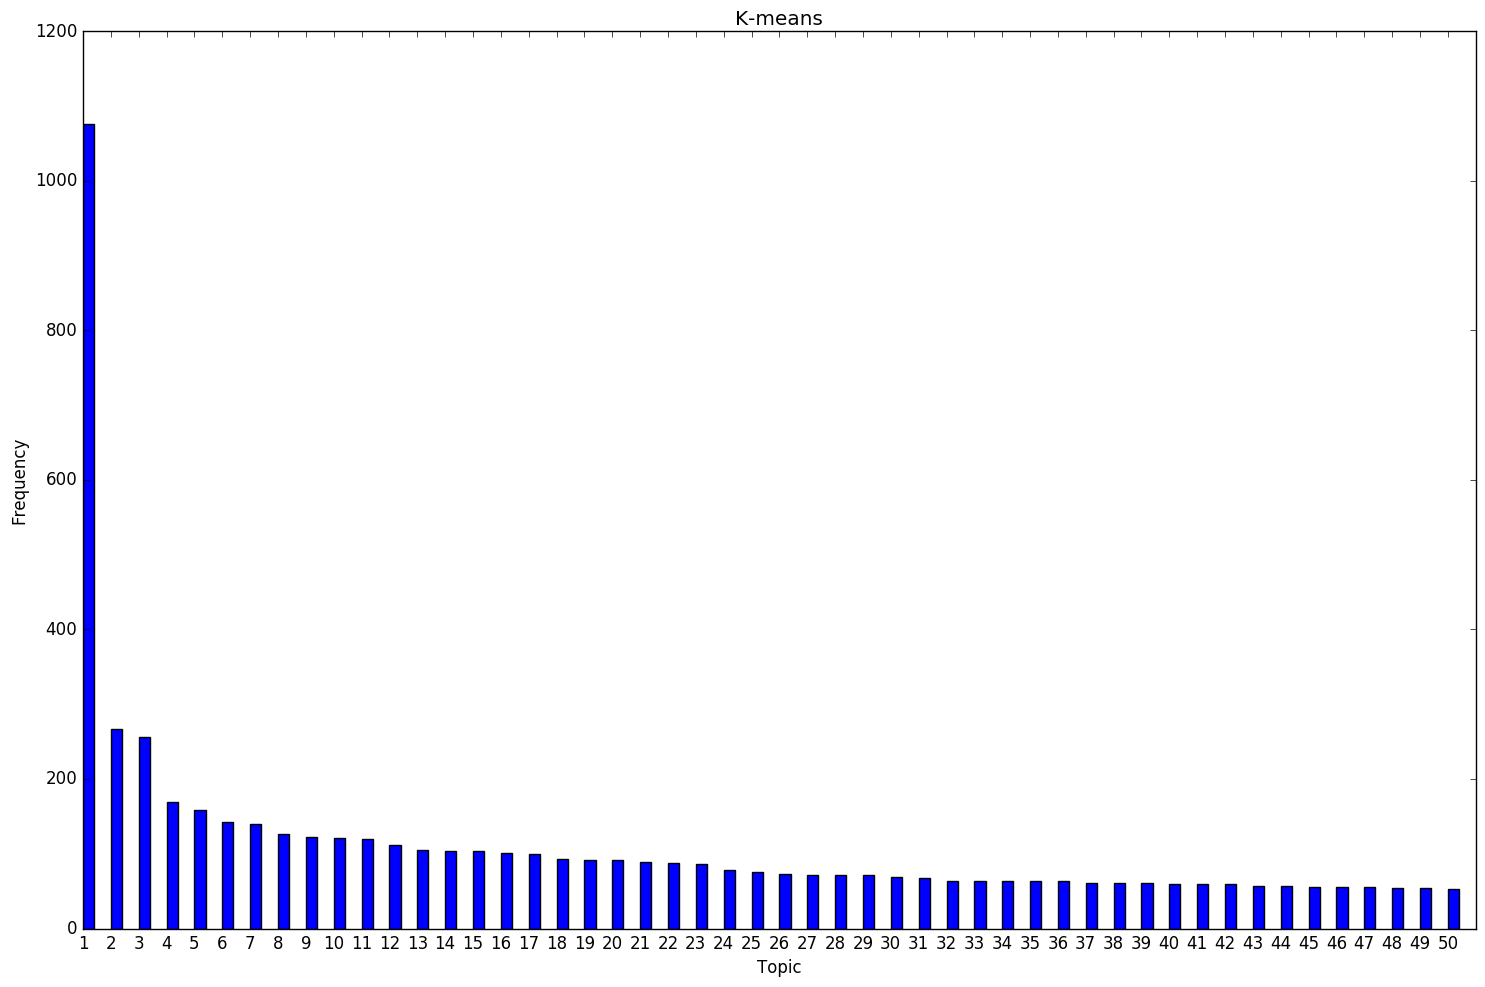

In [53]:
x_data = []
y_data = []
for key, value in sorted(km_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 50:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('w')
plt.bar(ind, y_data)
plt.xticks(ind, x_data)
plt.title("K-means")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.tight_layout()
fig.savefig('tmp/size_chart_km.png')
plt.show()

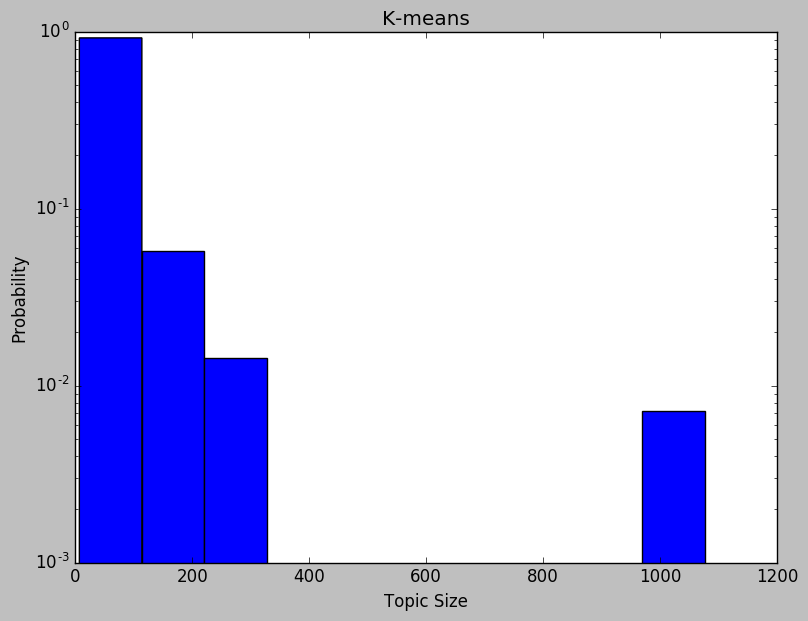

In [54]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    fig = plt.figure()
    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.tight_layout()
    plt.title("K-means")
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")
    fig.savefig('tmp/prob_chart_km.png')

topics_to_prob_dist(km_topics)

In [55]:
km_tfidf_topics = {}

for k, vs in km_topics.items():
    km_tfidf_topics[k] = []
    for v in vs:
        km_tfidf_topics[k].append(docs[v]['tfidf'])

In [56]:
km_labels_true = {}

for k, vs in km_topics.items():
    km_labels_true[k] = []
    for v in vs:
        km_labels_true[k].append(docs[v]['section_id'])

In [57]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(km_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(km_tfidf_topics)))

Overall Similarity 0.237
Inter Cluster 0.113
